<a href="https://colab.research.google.com/github/AliciaFalconCaro/PythonColabExamples/blob/main/StatisticalAnalysisBetweenModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-posthocs


In [ ]:
import numpy as np
from scipy.io import loadmat

#DAOT ideal vs Competing Methods:
mat_data = loadmat('Dataset1_SubGesturesFullBessels_LOSOkfolds.mat')
IdealDAOTModel = np.array(mat_data['ValAccuracy'])/100
print(IdealDAOTModel.shape)

#Competing Method 1: 2/3 DAOT
mat_data = loadmat('Dataset1_SubGestures2-3Bessels_LOSOkfolds.mat')
DAOTModel2_3 = np.array(mat_data['ValAccuracy'])/100

#Competing Method 1: EEGNet
mat_data = loadmat('Dataset1_SubGesturesEEGNet_LOSOkfolds.mat')
EEGNetModel = np.array(mat_data['ValAccuracy'])/100
print(EEGNetModel.shape)

#Competing Method 1: SCCNet
mat_data = loadmat('Dataset1_SubGesturesSCCNet_LOSOkfolds.mat')
SCCNetModel = np.array(mat_data['ValAccuracy'])/100

(14, 1)
(14, 1)


In [ ]:
# Combine the arrays into a single (14, 4) array
combined_data = np.column_stack((IdealDAOTModel, DAOTModel2_3, EEGNetModel, SCCNetModel))

print("Combined Data Shape:", combined_data.shape)  # Should output (14, 4)
print("Combined Data:\n", combined_data)

Combined Data Shape: (14, 4)
Combined Data:
 [[1.         0.7        0.         0.        ]
 [1.         0.6        0.2        0.        ]
 [1.         0.8        0.3        0.3       ]
 [1.         0.6142857  0.         0.1       ]
 [1.         0.8285714  0.1        0.2       ]
 [0.98571426 0.64285713 0.1        0.4       ]
 [1.         0.8        0.2        0.        ]
 [1.         0.62857143 0.2        0.1       ]
 [1.         0.6        0.2        0.        ]
 [1.         0.68571426 0.1        0.1       ]
 [1.         0.7        0.         0.        ]
 [1.         0.8        0.1        0.        ]
 [1.         0.52857143 0.4        0.2       ]
 [1.         0.81428574 0.5        0.1       ]]


In [ ]:
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Step 1: Rank the models within each fold
ranked_data = np.apply_along_axis(lambda x: pd.Series(x).rank().values, axis=1, arr=combined_data)

# Step 2: Calculate fold weights based on the differences of model ranks
fold_means = np.mean(ranked_data, axis=1)
fold_weights = np.abs(ranked_data - fold_means[:, None]).sum(axis=1)

# Step 3: Calculate weighted ranks
weighted_ranks = ranked_data * fold_weights[:, None]

# Step 4: Compute Quade's test statistic
# Average the weighted ranks for each model
model_means = np.mean(weighted_ranks, axis=0)

# Compute the mean of weighted ranks overall
overall_mean = np.mean(weighted_ranks)

# Quade's F-statistic formula
ss_between = len(combined_data) * np.sum((model_means - overall_mean) ** 2)
ss_within = np.sum((weighted_ranks - model_means) ** 2)
quade_statistic = (ss_between / (combined_data.shape[1] - 1)) / (ss_within / (combined_data.size - combined_data.shape[1]))

print("Quade Statistic:", quade_statistic)

# Step 5: Post-hoc tests if significant (pairwise comparisons)
# Use Nemenyi test to find out which models differ if the Quade statistic is significant
p_values = sp.posthoc_nemenyi_friedman(ranked_data)
print("Post-hoc p-values (Nemenyi test):\n", p_values)


Quade Statistic: 248.81720430107526
Post-hoc p-values (Nemenyi test):
               0         1         2             3
0  1.000000e+00  0.170052  0.000008  3.642340e-07
1  1.700516e-01  1.000000  0.027748  4.232164e-03
2  8.100149e-06  0.027748  1.000000  9.364803e-01
3  3.642340e-07  0.004232  0.936480  1.000000e+00


Quade Statistic: 13.570093457943923
Post-hoc p-values (Nemenyi test):
      0    1    2
0  1.0  1.0  1.0
1  1.0  1.0  1.0
2  1.0  1.0  1.0


(14,)
[1.         0.8        0.7        1.         0.9        0.88571426
 0.8        0.8        0.8        0.9        1.         0.9
 0.6        0.5       ]


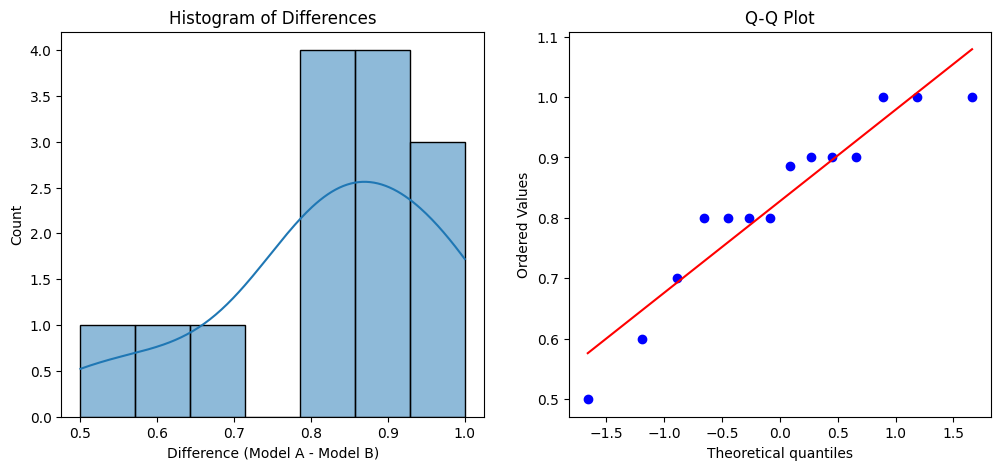

Shapiro-Wilk Test: Statistic=0.9028063094974518, p-value=0.12387827290661124
Kolmogorov-Smirnov Test: Statistic=0.20938230179722614, p-value=0.5056945571407719


In [ ]:
## Other statistical tests

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Step 1: Calculate differences
differences = IdealDAOTModel.flatten() - EEGNetModel.flatten()
print(differences.shape)
print(differences)

# Step 2: Visual Inspection
# Histogram
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(differences, kde=True)
plt.title('Histogram of Differences')
plt.xlabel('Difference (Model A - Model B)')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(differences, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Step 3: Statistical Tests for Normality
shapiro_stat, shapiro_p = stats.shapiro(differences)
ks_stat, ks_p = stats.kstest(differences, 'norm', args=(np.mean(differences), np.std(differences)))

print(f'Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}')
print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p}')


In [ ]:
t_statistic, p_value_ttest = stats.ttest_rel(IdealDAOTModel, EEGNetModel)
# Wilcoxon signed-rank test
w_statistic, w_p_value = stats.wilcoxon(differences)

# Print results
print(f"Paired t-test: t-statistic = {t_statistic}, p-value = {p_value_ttest}")
print(f'Wilcoxon Signed-Rank Test: W-statistic={w_statistic}, p-value={w_p_value}')


Paired t-test: t-statistic = [20.8497759], p-value = [2.24540074e-11]
Wilcoxon Signed-Rank Test: W-statistic=0.0, p-value=0.0001220703125


In [ ]:
mean_a = np.mean(IdealDAOTModel)
mean_b = np.mean(EEGNetModel)
std_a = np.std(IdealDAOTModel, ddof=1)
std_b = np.std(EEGNetModel, ddof=1)

cohen_d = (mean_a - mean_b) / np.sqrt((std_a**2 + std_b**2) / 2)
print(f"Cohen's d: {cohen_d}")

Cohen's d: 7.852577532619894


In [ ]:
differences1 = [m1 - m2 for m1, m2 in zip(IdealDAOTModel, EEGNetModel)]
print(differences1)
differences2 = IdealDAOTModel - EEGNetModel
print(differences2)

[array([1.]), array([0.8]), array([0.7]), array([1.]), array([0.9]), array([0.88571426]), array([0.8]), array([0.8]), array([0.8]), array([0.9]), array([1.]), array([0.9]), array([0.6]), array([0.5])]
[[1.        ]
 [0.8       ]
 [0.7       ]
 [1.        ]
 [0.9       ]
 [0.88571426]
 [0.8       ]
 [0.8       ]
 [0.8       ]
 [0.9       ]
 [1.        ]
 [0.9       ]
 [0.6       ]
 [0.5       ]]


In [ ]:
from scipy.stats import wilcoxon

#for each pairwise value
[stat, p_value] = wilcoxon(differences2)
print('Comparison: Model Ideal DAOT vs Model 2/3 DAOT, p-value: ', (p_value))

#for each pairwise value
[stat, p_value] = wilcoxon(IdealDAOTModel, EEGNetModel)
print('Comparison: Model Ideal DAOT vs Model EEGNet, p-value: ', (p_value))

#for each pairwise value
[stat, p_value] = wilcoxon(IdealDAOTModel, SCCNetModel)
print('Comparison: Model Ideal DAOT vs Model SCCNet, p-value: ', (p_value))


Comparison: Model Ideal DAOT vs Model 2/3 DAOT, p-value:  [0.00012207]
Comparison: Model Ideal DAOT vs Model EEGNet, p-value:  [0.00012207]
Comparison: Model Ideal DAOT vs Model SCCNet, p-value:  [0.00012207]


In [ ]:
from scipy.stats import wilcoxon

#for each pairwise value
[stat, p_value] = wilcoxon(DAOTModel2_3, IdealDAOTModel)
print('Comparison: Model 2/3 DAOT vs Model Ideal DAOT, p-value: ', (p_value))

#for each pairwise value
[stat, p_value] = wilcoxon(DAOTModel2_3, EEGNetModel)
print('Comparison: Model 2/3 DAOT vs Model EEGNet, p-value: ', (p_value))

#for each pairwise value
[stat, p_value] = wilcoxon(DAOTModel2_3, SCCNetModel)
print('Comparison: Model 2/3 DAOT vs Model SCCNet, p-value: ', (p_value))

Comparison: Model 2/3 DAOT vs Model Ideal DAOT, p-value:  [0.00012207]
Comparison: Model 2/3 DAOT vs Model EEGNet, p-value:  [0.00012207]
Comparison: Model 2/3 DAOT vs Model SCCNet, p-value:  [0.00012207]
